In [1]:
import cudf
#documentaion: https://docs.rapids.ai/api/cuml/stable/api/#preprocessing-metrics-and-utilities
import cuml
import cupy as cp
import numpy as np
import pandas as pd
import seaborn as sns 
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [3]:
import gc
# Frees GPU memory
gc.collect()

24

In [4]:
cp.get_default_memory_pool().free_all_blocks() # more freeing memory

In [5]:
total_mem, free_mem = cp.cuda.runtime.memGetInfo() #this is for checking your free and total gpu memory
print(total_mem)
print(free_mem) #note 10th digit is gb place

7463763968
8589410304


# Data set information
Data collected from UC Irvince, originated as product reviews on durgs.com
https://archive.ics.uci.edu/dataset/462/drug+review+dataset+drugs+com

The intended independent X is the review feature
intended dependent Y is the rating feature

In [2]:
from ucimlrepo import fetch_ucirepo 
  
# fetch dataset 
reviews = fetch_ucirepo(id=462) #215063 instances, 7 features

In [3]:
# data (as pandas dataframes) 
importX = reviews.data.features 
y = reviews.data.targets #empty 
  
# metadata 
print(reviews.metadata) 
  
# variable information 
print(reviews.variables)

{'uci_id': 462, 'name': 'Drug Reviews (Drugs.com)', 'repository_url': 'https://archive.ics.uci.edu/dataset/462/drug+review+dataset+drugs+com', 'data_url': 'https://archive.ics.uci.edu/static/public/462/data.csv', 'abstract': 'The dataset provides patient reviews on specific drugs along with related conditions and a 10 star patient rating reflecting overall patient satisfaction.', 'area': 'Health and Medicine', 'tasks': ['Classification', 'Regression', 'Clustering'], 'characteristics': ['Multivariate', 'Text'], 'num_instances': 215063, 'num_features': 6, 'feature_types': ['Integer'], 'demographics': [], 'target_col': None, 'index_col': ['id'], 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 2018, 'last_updated': 'Wed Apr 03 2024', 'dataset_doi': '10.24432/C5SK5S', 'creators': ['Surya Kallumadi', 'Felix Grer'], 'intro_paper': {'ID': 407, 'type': 'NATIVE', 'title': 'Aspect-Based Sentiment Analysis of Drug Reviews Applying Cross-Domain and Cross-Data 

In [260]:
importX.isnull().sum() # no holes in data i intened to work with

drugName          0
condition      1194
review            0
rating            0
date              0
usefulCount       0
dtype: int64

In [261]:
importX.head() #For the purposes of this project review will be x value and rating will be y value

,drugName,condition,review,rating,date,usefulCount
0,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",9,20-May-12,27
1,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8,27-Apr-10,192
2,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5,14-Dec-09,17
3,Ortho Evra,Birth Control,"""This is my first time using any form of birth...",8,3-Nov-15,10
4,Buprenorphine / naloxone,Opiate Dependence,"""Suboxone has completely turned my life around...",9,27-Nov-16,37


In [262]:
reviews.keys()

dict_keys(['data', 'metadata', 'variables'])

In [263]:
print(importX['review'].head(20))

0     "It has no side effect, I take it in combinati...
1     "My son is halfway through his fourth week of ...
2     "I used to take another oral contraceptive, wh...
3     "This is my first time using any form of birth...
4     "Suboxone has completely turned my life around...
5     "2nd day on 5mg started to work with rock hard...
6     "He pulled out, but he cummed a bit in me. I t...
7     "Abilify changed my life. There is hope. I was...
8     " I Ve had  nothing but problems with the Kepp...
9     "I had been on the pill for many years. When m...
10    "I have been on this medication almost two wee...
11    "I have taken anti-depressants for years, with...
12    "I had Crohn&#039;s with a resection 30 years ...
13    "Have a little bit of a lingering cough from a...
14    "Started Nexplanon 2 months ago because I have...
15    "I have been taking Saxenda since July 2016.  ...
16    "This drug worked very well for me and cleared...
17    "I&#039;ve been taking amitriptyline since

Need to clean the data and remove the html entities in it

In [4]:
import html
import re
import nltk
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from nltk.stem import PorterStemmer #applies stemming to reach root words, running to run etc.
stemmer = PorterStemmer()

def clean_review(text):
    # Decodes HTML entities
    text = html.unescape(text)
    text = text.lower()
    # Removes special characters and numbers
    text = re.sub(r"[^a-zA-Z\s]", "", text)
    # Removes extra whitespace
    text = " ".join(text.split())
    #stop words will again be removed with the vectorizer but just in case:
    text = " ".join([word for word in text.split() if word not in ENGLISH_STOP_WORDS])
    text = " ".join([stemmer.stem(word) for word in text.split()])
    return text


importX['review'] = importX['review'].apply(clean_review)

# Check the results
print(importX['review'])

0                          effect combin bystol mg fish oil
1         son halfway fourth week intuniv concern began ...
2         use oral contracept pill cycl happi light peri...
3         time use form birth control im glad went patch...
4         suboxon complet turn life feel healthier im ex...
                                ...                        
215058    taken tamoxifen year effect sever sweat depres...
215059    ive take lexapro escitaploprgram februari id l...
215060    im marri year old kid take pill hassl decid mi...
215061    prescrib nucynta sever neckshould pain take mg...
215062                                                 work
Name: review, Length: 215063, dtype: object


/tmp/ipykernel_23498/2716919279.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  importX['review'] = importX['review'].apply(clean_review)


In [33]:
from cuml.feature_extraction.text import TfidfVectorizer
from cuml.model_selection import train_test_split

df = cudf.DataFrame.from_pandas(importX[['review', 'rating']]) #converting to cudf format so we can use gpu
X = df['review']
y = df['rating']

In [73]:
print(X.head(20))

0     "It has no side effect, I take it in combinati...
1     "My son is halfway through his fourth week of ...
2     "I used to take another oral contraceptive, wh...
3     "This is my first time using any form of birth...
4     "Suboxone has completely turned my life around...
5     "2nd day on 5mg started to work with rock hard...
6     "He pulled out, but he cummed a bit in me. I t...
7     "Abilify changed my life. There is hope. I was...
8     " I Ve had  nothing but problems with the Kepp...
9     "I had been on the pill for many years. When m...
10    "I have been on this medication almost two wee...
11    "I have taken anti-depressants for years, with...
12    "I had Crohn&#039;s with a resection 30 years ...
13    "Have a little bit of a lingering cough from a...
14    "Started Nexplanon 2 months ago because I have...
15    "I have been taking Saxenda since July 2016.  ...
16    "This drug worked very well for me and cleared...
17    "I&#039;ve been taking amitriptyline since

In [75]:
#Terms i want/need to be included in the tfidf as the vocabulary parameter:
#seemed more effective to use max_features which is mutually incompatible and likely already included them, but max_features is FARRR less memory efficient

# Converts to lowercase
X = X.str.lower()

# Tokenizes
X = X.str.replace(r'[^\w\s]', '', regex=True)

# Defines the initial pharma_vocab
pharma_vocab = [
    "effective", "relief", "works", "recommend", "improvement", "satisfied",
    "better", "helpful", "excellent", "amazing", "side effects", "ineffective", "pain", "worse", "problems", "disappointed",
    "nausea", "dizziness", "allergic", "headache", "relief", "fast", "slow", "duration", "onset", "impact", "lasting",
    "tolerable", "intolerable", "severe", "dose", "dosage", "frequency", "pill", "tablet", "daily", "weekly", 
    "twice", "missed", "anxiety", "depression", "pain", "inflammation", "infection", "fever",
    "nausea", "fatigue", "insomnia", "recovery", "affordable", "expensive", "price", "insurance", "coverage", "generic",
    "brand", "pharmacy", "prescription", "doctor", "pharmacist", "refill", "instructions",
    "follow-up", "consult", "discontinue", "warning", "caution", "label", "instructions", "review", "experience",
    "recommend", "avoid"
]

#i kept getting an error because some term in my premade vocabulary did not appear in any reviews
text_data = X.to_arrow().to_pylist()  # Convert to list of strings
filtered_vocab = [word for word in pharma_vocab if any(word in doc for doc in text_data)]
X = df['review']

In [76]:
print("Filtered Vocabulary:", filtered_vocab)

Filtered Vocabulary: ['effective', 'relief', 'works', 'recommend', 'improvement', 'satisfied', 'better', 'helpful', 'excellent', 'amazing', 'side effects', 'ineffective', 'pain', 'worse', 'problems', 'disappointed', 'nausea', 'dizziness', 'allergic', 'headache', 'relief', 'fast', 'slow', 'duration', 'onset', 'impact', 'lasting', 'tolerable', 'intolerable', 'severe', 'dose', 'dosage', 'frequency', 'pill', 'tablet', 'daily', 'weekly', 'twice', 'missed', 'anxiety', 'depression', 'pain', 'inflammation', 'infection', 'fever', 'nausea', 'fatigue', 'insomnia', 'recovery', 'affordable', 'expensive', 'price', 'insurance', 'coverage', 'generic', 'brand', 'pharmacy', 'prescription', 'doctor', 'pharmacist', 'refill', 'instructions', 'consult', 'discontinue', 'warning', 'caution', 'label', 'instructions', 'review', 'experience', 'recommend', 'avoid']


In [79]:
print(type(filtered_vocab))
print(type(X))

<class 'list'>
<class 'cudf.core.series.Series'>


In [80]:
text_data = X.to_pandas().tolist()  # Each element is a document

# Find words in filtered_vocab not present in any document in X
missing_vocab = [word for word in filtered_vocab if not any(word in doc for doc in text_data)]

# Print missing words, if any
if missing_vocab:
    print(f"These words from filtered_vocab are not in X: {missing_vocab}")
else:
    print("All words in filtered_vocab are present in X.")

All words in filtered_vocab are present in X.


In [30]:
#I will attempt to use ngram with the bigrams unless it leads to computational issues

## Exploratory Data Analysis for Target Class Y


In [21]:
print(importX["rating"].min())
print(importX["rating"].max())

1
10


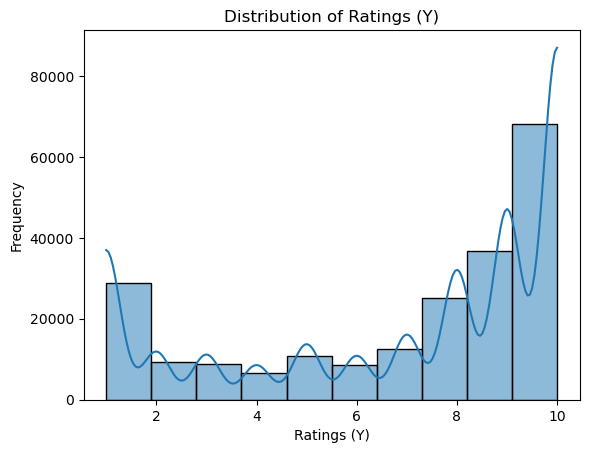

-0.7955294148977783


In [31]:
#histogram to visualize distribution of our y value rating
sns.histplot(importX['rating'], bins=10, kde=True)
plt.title('Distribution of Ratings (Y)')
plt.xlabel('Ratings (Y)')
plt.ylabel('Frequency')
plt.show()

#skewness
skewness = importX['rating'].skew()
print(skewness)

In [32]:
print(importX['rating'].mean()) #some exploration of y value
print(importX['rating'].median())
print(importX['rating'].std())

6.990007579174474
8.0
3.27555449759033


Why not balance the data if it skews towards a positive review?
- This skew towards positive is reflected in our real world dataset so the model should also reflect the trend
- The most effective algorithm, Random Forest, mitigates class imbalance by design

In [33]:
print(f"Number of features (vocabulary size): {len(tfidfbigram.get_feature_names())}")

Number of features (vocabulary size): 20000


Kept for memorial purposes because it took several hours of my life:
This was an attempt to display the terms with highest mutual information for each rating, but unfortunately failed do to memory constraints
CuML doesn't have an implementation of the mutual info classifier so i had attempt it with sklearn running on the cpu
unsuprisingly, this didn't fair well with matrices of 215k instances and a 10k term vocabulary

In [ ]:
# from sklearn.feature_selection import mutual_info_classif
# from scipy.sparse import csr_matrix

# tfidfbigram_matrix_scipy = csr_matrix(tfidfbigram_matrix.get()) #.get brings it from gpu to cpu, then scupts for scipy
# tfidfbigram_matrix_rounded = tfidfbigram_matrix_scipy.copy()
# tfidfbigram_matrix_rounded.data = tfidfbigram_matrix_rounded.data.round(decimals=0)
# # Select top terms for correlation analysis
# from joblib import parallel_backend

# with parallel_backend('loky'):
#     mutual_info = mutual_info_classif(tfidfbigram_matrix_rounded, y.to_pandas().values, discrete_features=True, n_jobs=-2)
# #mutual_info = mutual_info_classif(tfidfbigram_matrix_rounded, y.to_pandas().values, discrete_features=True, n_jobs=-2)
# top_indices = mutual_info.argsort()[-10:][::-1]

# # Display terms with highest mutual information
# top_terms = [(terms[i], mutual_info[i]) for i in top_indices]
# print("Top terms by mutual information with ratings:", top_terms)

# Attempted PCA for Visualization

In [ ]:
from cuml.decomposition import PCA
import matplotlib.pyplot as plt

#reducing the tfidf matrix to 2 dimensions for visualization, i ran out of memory trying it with the bigram matrix so only attempting with the regular vocabulary
pca = PCA(n_components=2)
X_pca = pca.fit_transform(tfidf_matrix)

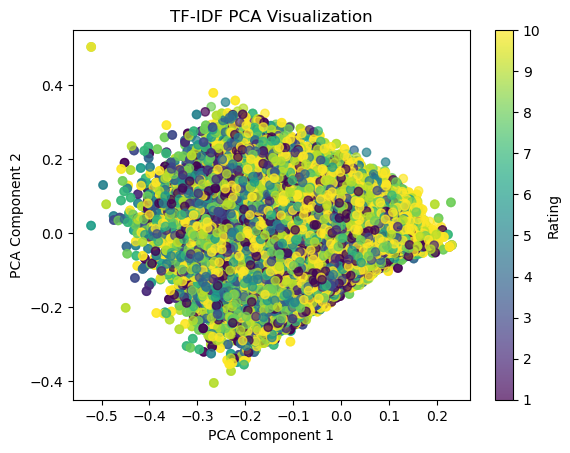

In [41]:
X_pca = X_pca.get() #explicit conversion from gpu to cpu-backed numpy array
ratings = df["rating"].to_numpy()
# Scatter plot of reduced dimensions
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=importX['rating'], cmap='viridis', alpha=0.7)
plt.colorbar(label="Rating")
plt.title("TF-IDF PCA Visualization")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.show()

doesn't look like pca of the tfidf is going to be too much help in sorting these components

## TFIDF setup

In [14]:
from cupyx.scipy.sparse import csr_matrix as cp_csr_matrix
#use when needed

# Convert to CuPy sparse matrix
tfidf_sparse = cp_csr_matrix(tfidf_matrix) #converting from sparse on cpu side to spare on gpu side (CuPY)
#i lied it was already cpu side darn

NameError: name 'tfidf_matrix' is not defined

In [14]:
print(type(tfidf_matrix))
print(type(tfidf_dense))#type double checks
print(type(df["rating"]))

<class 'cupyx.scipy.sparse._csr.csr_matrix'>
<class 'cupy.ndarray'>
<class 'cudf.core.series.Series'>


In [40]:
from sklearn.model_selection import train_test_split as sklearn_train_test_split
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay, mean_squared_error, mean_absolute_error,r2_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from scipy.sparse import csr_matrix as scipy_csr_matrix

In [6]:
from sklearn.feature_extraction.text import TfidfVectorizer as sklearn_tfidf_vectorizer

In [7]:
tfidf_scipy_vectorizer = sklearn_tfidf_vectorizer(
    max_df=0.7,                # Ignore terms in > 70% of documents
    min_df=5,                  # Ignore terms in < 5 documents
    max_features=5000,
    stop_words='english'      
)
tfidf_scipy = tfidf_scipy_vectorizer.fit_transform(importX['review'])

In [30]:
tfidf_scipy_bi_vec = sklearn_tfidf_vectorizer(
    max_df=0.5,                # Ignore terms in > 50% of documents
    min_df=5,                  # Ignore terms in < 5 documents
    max_features=20000,
    stop_words='english',
    ngram_range=(1, 2) # now looking at bigrams
)
tfidf_scipy_bi = tfidf_scipy_bi_vec.fit_transform(importX['review'])

In [155]:
print(type(tfidf_scipy))

<class 'scipy.sparse._csr.csr_matrix'>


# TFIDF (X Feature) Preliminary Analysis

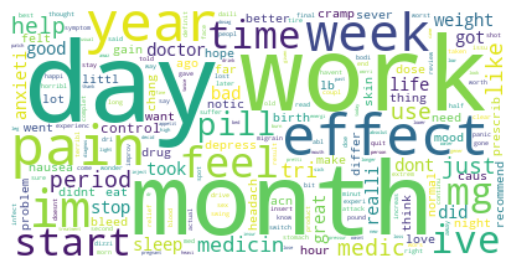

In [8]:
from wordcloud import WordCloud
feature_names = tfidf_scipy_vectorizer.get_feature_names_out()
tfidf_scores = np.asarray(tfidf_scipy.sum(axis=0)).flatten()
# Generate a word cloud for the TF-IDF features
wordcloud = WordCloud(background_color="white").generate_from_frequencies(
    dict(zip(feature_names, tfidf_scores))
)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

Specific Word Correlation

In [13]:
from scipy.stats import pearsonr
ratings = np.array(importX['rating'])
correlations = []
for i in range(tfidf_scipy.shape[1]):
    word_column = tfidf_scipy.getcol(i).toarray().flatten()
    corr, _ = pearsonr(word_column, ratings)
    correlations.append((feature_names[i], corr))
correlations_df = pd.DataFrame(correlations, columns=['Word', 'Correlation'])
correlations_df['AbsCorrelation'] = correlations_df['Correlation'].abs()
correlations_df = correlations_df.sort_values(by='AbsCorrelation', ascending=False)

Top 10 Positively Correlated Words:
            Word  Correlation  AbsCorrelation
4900        wors    -0.151871        0.151871
4902       worst    -0.149392        0.149392
2058     horribl    -0.136184        0.136184
4946        year     0.130609        0.130609
482        bleed    -0.117626        0.117626
2471        life     0.116477        0.116477
2557        love     0.114450        0.114450
4170        stop    -0.113628        0.113628
1879       great     0.108564        0.108564
437         best     0.105496        0.105496
156         amaz     0.098632        0.098632
4893        work     0.096672        0.096672
4378     terribl    -0.095528        0.095528
2740      miracl     0.094787        0.094787
696         caus    -0.086205        0.086205
334           aw    -0.085950        0.085950
3605       remov    -0.081364        0.081364
1559      extrem    -0.080526        0.080526
4887      wonder     0.078656        0.078656
4392       thank     0.076663        0.07666

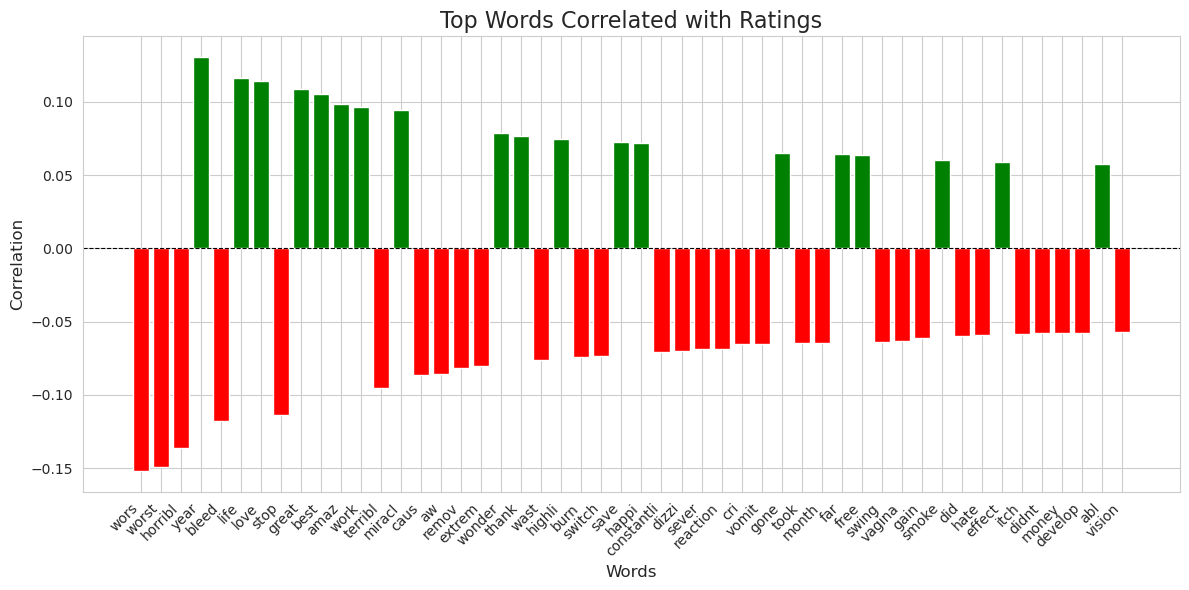

In [25]:
print("Top 10 Positively Correlated Words:")
print(correlations_df.head(30))

top_words = correlations_df.head(50)
sns.set_style("whitegrid")
plt.figure(figsize=(12, 6))
colors = ['green' if corr > 0 else 'red' for corr in top_words['Correlation']]
plt.bar(top_words['Word'], top_words['Correlation'], color=colors)
plt.title('Top Words Correlated with Ratings', fontsize=16)
plt.xlabel('Words', fontsize=12)
plt.ylabel('Correlation', fontsize=12)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.axhline(0, color='black', linewidth=0.8, linestyle='--')
plt.tight_layout()
plt.show()

In [22]:
# from cuml.experimental import pearson_correlation  
# from cuml.common.input_utils import input_to_cuml_array

# tfidf_cupy = cp.sparse.csr_matrix(tfidf_scipy)
# y_cupy = cp.array(importX['rating'])
# pearson_corr = pearson_correlation()
# correlations_cupy = pearson_corr(tfidf_cupy, y_cupy)
# correlations = correlations_cupy.get()
# print("Top Correlated Terms with Rating:\n", correlations.head(10))

In [269]:
#tfidf_scipy = csr_matrix(tfidf_sparse.get()) # sparse for cpu sike nope just rewrote it so i could switch up the parameters

In [28]:
Xs_train, Xs_test, ys_train, ys_test = sklearn_train_test_split(tfidf_scipy, importX["rating"], test_size=0.2, random_state=42) #sparse model splits(cpu)

In [32]:
Xsb_train, Xsb_test, ysb_train, ysb_test = sklearn_train_test_split(tfidf_scipy_bi, importX["rating"], test_size=0.2, random_state=42) #bigram splits(cpu)

In [39]:
print(type(Xs_train))
print(type(tfidf_matrix))
print(type(importX["rating"]))

<class 'scipy.sparse._csr.csr_matrix'>
<class 'cupyx.scipy.sparse._csr.csr_matrix'>
<class 'pandas.core.series.Series'>


## Algorithms

Sparse:
1. Multinomial Naive Bayes
2. KNN Classifier with PCA
3. Support Vector Machine Classification # didnt work
4. Gradient Boosting with XGBoost

Dense:
1. Suppost Vector Machine Classification
2. Random Forests

# Sparse Matrix Capable Algorithms: Multinomial NB, Logistic Regression, SVM, XGboost

/home/unavrgjoe/miniforge3/envs/rapids-24.10/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/unavrgjoe/miniforge3/envs/rapids-24.10/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/unavrgjoe/miniforge3/envs/rapids-24.10/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

Classification Report:
               precision    recall  f1-score   support

           1       0.48      0.52      0.50      5800
           2       0.33      0.00      0.01      1879
           3       0.44      0.01      0.01      1744
           4       0.00      0.00      0.00      1299
           5       0.27      0.00      0.01      2218
           6       0.00      0.00      0.00      1727
           7       0.00      0.00      0.00      2483
           8       0.28      0.02      0.04      5102
           9       0.24      0.09      0.13      7244
          10       0.38      0.94      0.54     13517

    accuracy                           0.38     43013
   macro avg       0.24      0.16      0.12     43013
weighted avg       0.30      0.38      0.27     43013

Mean Squared Error (MSE): 13.3248
Mean Absolute Error (MAE): 2.2812
R² Score: -0.2414


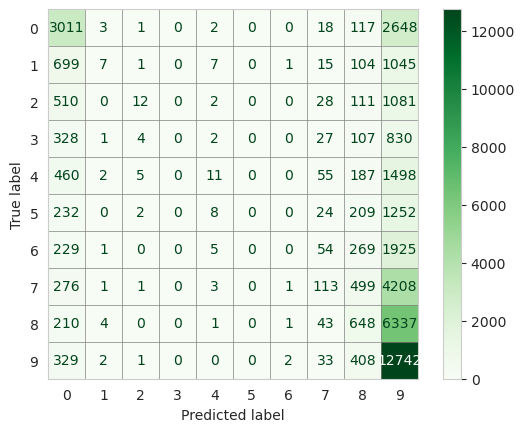

In [53]:
MultinomialNB_sklearn = MultinomialNB(alpha=1.0) # sparse model
MultinomialNB_sklearn.fit(Xs_train, ys_train)
ys_predict = MultinomialNB_sklearn.predict(Xs_test)
print("Classification Report:\n", classification_report(ys_test, ys_predict))
cm = confusion_matrix(ys_test, ys_predict)
ConfusionMatrixDisplay(cm).plot(cmap='Greens')
ax = plt.gca()  #have to reset messy grid
ax.set_xticks([x - 0.5 for x in range(len(cm) + 1)], minor=True) 
ax.set_yticks([y - 0.5 for y in range(len(cm) + 1)], minor=True)
ax.grid(visible=True, which='minor', color='gray', linestyle='-', linewidth=0.5)
ax.tick_params(which="minor", size=0)
ax.grid(visible=False, which='major')
mse = mean_squared_error(ys_test, ys_predict)
mae = mean_absolute_error(ys_test, ys_predict)
r2 = r2_score(ys_test, ys_predict)
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"R² Score: {r2:.4f}")

In [ ]:
#accuracy improved from .37 to .39 by increasing max number of features from 1000 to 5000

Classification Report:
               precision    recall  f1-score   support

           1       0.46      0.73      0.56      5800
           2       0.23      0.06      0.09      1879
           3       0.24      0.06      0.10      1744
           4       0.25      0.04      0.07      1299
           5       0.21      0.09      0.12      2218
           6       0.21      0.04      0.06      1727
           7       0.20      0.06      0.09      2483
           8       0.26      0.18      0.21      5102
           9       0.31      0.23      0.26      7244
          10       0.50      0.81      0.62     13517

    accuracy                           0.43     43013
   macro avg       0.29      0.23      0.22     43013
weighted avg       0.36      0.43      0.36     43013

Mean Squared Error (MSE): 9.3867
Mean Absolute Error (MAE): 1.8018
R² Score: 0.1255


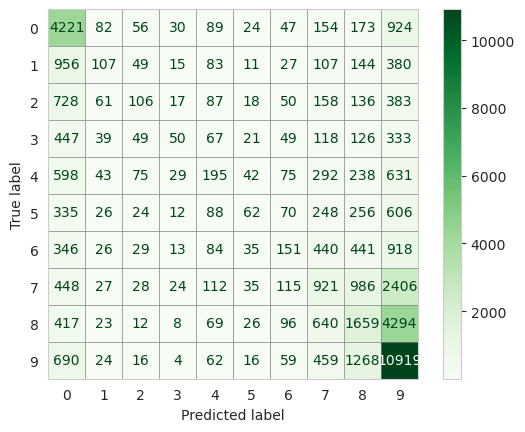

In [56]:
LR_sklearn = LogisticRegression(max_iter=1000) # sparse model
LR_sklearn.fit(Xs_train, ys_train)
ys_predict = LR_sklearn.predict(Xs_test)
print("Classification Report:\n", classification_report(ys_test, ys_predict))
cm = confusion_matrix(ys_test, ys_predict)
ConfusionMatrixDisplay(cm).plot(cmap='Greens')
ax = plt.gca()  #have to reset messy grid
ax.set_xticks([x - 0.5 for x in range(len(cm) + 1)], minor=True) 
ax.set_yticks([y - 0.5 for y in range(len(cm) + 1)], minor=True)
ax.grid(visible=True, which='minor', color='gray', linestyle='-', linewidth=0.5)
ax.tick_params(which="minor", size=0)
ax.grid(visible=False, which='major')
mse = mean_squared_error(ys_test, ys_predict)
mae = mean_absolute_error(ys_test, ys_predict)
r2 = r2_score(ys_test, ys_predict)
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"R² Score: {r2:.4f}")

In [ ]:
#accuracy improved from .43 to .44 by increasing max number of features from 1000 to 5000

# Sparse Algorithms with Bigrams

Classification Report:
               precision    recall  f1-score   support

           1       0.47      0.65      0.54      5800
           2       0.50      0.03      0.05      1879
           3       0.40      0.03      0.06      1744
           4       0.87      0.01      0.02      1299
           5       0.34      0.04      0.08      2218
           6       0.67      0.00      0.00      1727
           7       0.47      0.01      0.01      2483
           8       0.31      0.08      0.13      5102
           9       0.29      0.18      0.23      7244
          10       0.43      0.91      0.58     13517

    accuracy                           0.42     43013
   macro avg       0.47      0.19      0.17     43013
weighted avg       0.42      0.42      0.32     43013

Mean Squared Error (MSE): 11.0275
Mean Absolute Error (MAE): 1.9944
R² Score: -0.0274


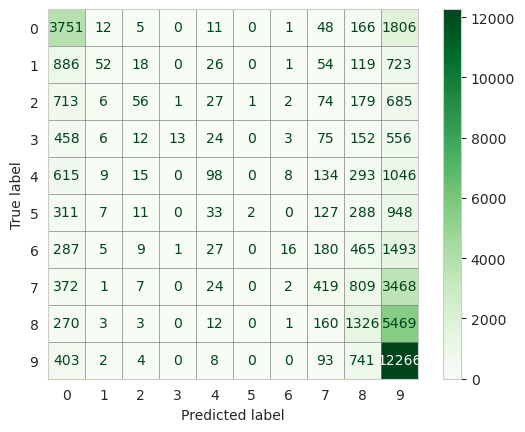

In [57]:
MultinomialNB_sklearn.fit(Xsb_train, ysb_train)
ysb_predict = MultinomialNB_sklearn.predict(Xsb_test)
print("Classification Report:\n", classification_report(ysb_test, ysb_predict))
cm = confusion_matrix(ysb_test, ysb_predict)
ConfusionMatrixDisplay(cm).plot(cmap='Greens')
ax = plt.gca()  #have to reset messy grid
ax.set_xticks([x - 0.5 for x in range(len(cm) + 1)], minor=True) 
ax.set_yticks([y - 0.5 for y in range(len(cm) + 1)], minor=True)
ax.grid(visible=True, which='minor', color='gray', linestyle='-', linewidth=0.5)
ax.tick_params(which="minor", size=0)
ax.grid(visible=False, which='major')
mse = mean_squared_error(ysb_test, ysb_predict)
mae = mean_absolute_error(ysb_test, ysb_predict)
r2 = r2_score(ysb_test, ysb_predict)
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"R² Score: {r2:.4f}")

In [ ]:
#use of bigrams on a 20000 max_feature dataset caused an accuracy increase from .39 to .42, 
#likely just from increasing number of features so im ruling out bigrams for this size of dataset and computational power

Classification Report:
               precision    recall  f1-score   support

           1       0.51      0.77      0.61      5800
           2       0.42      0.12      0.18      1879
           3       0.37      0.10      0.15      1744
           4       0.37      0.06      0.11      1299
           5       0.34      0.15      0.21      2218
           6       0.35      0.06      0.10      1727
           7       0.31      0.10      0.15      2483
           8       0.32      0.24      0.27      5102
           9       0.36      0.31      0.33      7244
          10       0.53      0.82      0.65     13517

    accuracy                           0.47     43013
   macro avg       0.39      0.27      0.28     43013
weighted avg       0.43      0.47      0.42     43013

Mean Squared Error (MSE): 7.9715
Mean Absolute Error (MAE): 1.5972
R² Score: 0.2573


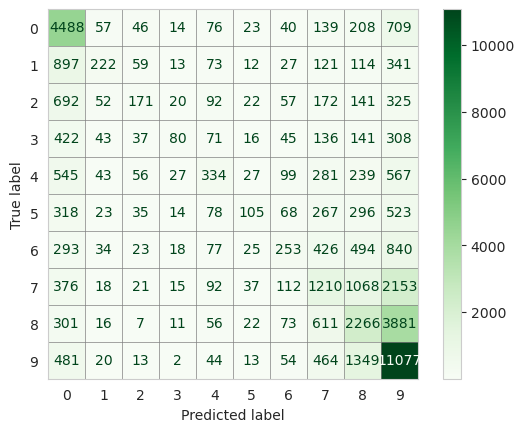

In [58]:
LR_sklearn.fit(Xsb_train, ysb_train)
ysb_predict = LR_sklearn.predict(Xsb_test)
print("Classification Report:\n", classification_report(ysb_test, ysb_predict))
cm = confusion_matrix(ysb_test, ysb_predict)
ConfusionMatrixDisplay(cm).plot(cmap='Greens')
ax = plt.gca()  #have to reset messy grid
ax.set_xticks([x - 0.5 for x in range(len(cm) + 1)], minor=True) 
ax.set_yticks([y - 0.5 for y in range(len(cm) + 1)], minor=True)
ax.grid(visible=True, which='minor', color='gray', linestyle='-', linewidth=0.5)
ax.tick_params(which="minor", size=0)
ax.grid(visible=False, which='major')
mse = mean_squared_error(ysb_test, ysb_predict)
mae = mean_absolute_error(ysb_test, ysb_predict)
r2 = r2_score(ysb_test, ysb_predict)
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"R² Score: {r2:.4f}")

In [167]:
#accuracy improved from .44 to .47 with features 10k to 20k and use of bigrams,
#i expect wide margins of error simply do to the fact that this is semantic analysis on a 10 pt rating scale,

In [11]:
from sklearn.svm import SVC

In [2]:
# from sklearn.model_selection import GridSearchCV
# param_grid = { 'C': [ 0.1, 1, 10,], 'kernel': ['linear']} #grid search was farrrr too slow

In [2]:
#svc = SVC(kernel = 'linear')

Support Vector Machine Classification was originally farrrr too computation intensive to run even with a sparse matrix on the cpu
TruncatedSVD was introduced to reduce the number of dimensions

...and it still failed to breach 10% in 10 minutes so i aborted the process and will be attempting with cuml

In [65]:
from sklearn.decomposition import TruncatedSVD

svd = TruncatedSVD(n_components=100, random_state=42)  #now 100 dimensions instead of 5000
Xsb_train300 = svd.fit_transform(Xsb_train) 
Xsb_test300 = svd.transform(Xsb_test)    

In [ ]:
svc_model = SVC(kernel='linear', C=1.0, verbose=1) #forced to use cpu because CuDF implementations require dense matrices
svc_model.fit(Xsb_train300, ys_train) #failed too many instances to calculate est. 21 million total instances

[LibSVM].......
*
optimization finished, #iter = 7538
obj = -14771.999984, rho = -0.999992
nSV = 14863, nBSV = 14681
.......
*
optimization finished, #iter = 7235
obj = -13947.999977, rho = -1.000019
nSV = 14066, nBSV = 13829
.....
*
optimization finished, #iter = 5693
obj = -10743.999978, rho = -1.000016
nSV = 10887, nBSV = 10607
...........
*...*.
*
optimization finished, #iter = 14806
obj = -16805.243328, rho = -1.264842
nSV = 17002, nBSV = 16864
.........
*...*.*
optimization finished, #iter = 12299
obj = -13229.631543, rho = -1.256952
nSV = 13441, nBSV = 13293
..........
*..*.*
optimization finished, #iter = 12939
obj = -16330.649745, rho = -1.411714
nSV = 16862, nBSV = 16732
..............
*.
*..*
optimization finished, #iter = 17125
obj = -22425.877743, rho = -1.015599
nSV = 23202, nBSV = 23058
........

In [ ]:
# ysb_predict = svc_model.predict(Xsb_test300)
# print("confusion matrix:\n", confusion_matrix(ysb_test,ysb_predict))
# print("classification report:\n", classification_report(ysb_test,ysb_predict))

Gradient Boosting, models using a series of decision trees with iterative error fixing

In [61]:
import xgboost as xgb

In [67]:
#importX.loc[:, 'rating'] = importX['rating'] +- 1 #used to fix an error where xgboost/otheralgorithm expects lower values and doesn't fix it

In [68]:
Xsb_train, Xsb_test, ysb_train, ysb_test = sklearn_train_test_split(tfidf_scipy_bi, importX["rating"], test_size=0.2, random_state=42)

In [69]:
xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric="logloss", n_estimators=1000)

xgb_model.fit(Xsb_train300, ysb_train, verbose=1)

ys_pred = xgb_model.predict(Xsb_test300)

/home/unavrgjoe/miniforge3/envs/rapids-24.10/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [17:58:14] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1727241199541/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


confusion matrix:
 [[ 4913    15    11     0    22     4    18    88   158   571]
 [  264  1291     7     2     7     1     3    41    69   194]
 [  192    10  1168     3    14     6     6    65    67   213]
 [  142     2     5   865    11     3     5    41    73   152]
 [  206    10     7     6  1429     3    20   116   123   298]
 [  127     3     4     1     5  1127    13    75   117   255]
 [  131     1     4     1    19     0  1560   121   208   438]
 [  149     8     3     1    14     3    26  3452   412  1034]
 [  166     6     4     1     6     8    17   227  5129  1680]
 [  282     4    12     4     9     0     9   182   679 12336]]
classification report:
               precision    recall  f1-score   support

           0       0.75      0.85      0.79      5800
           1       0.96      0.69      0.80      1879
           2       0.95      0.67      0.79      1744
           3       0.98      0.67      0.79      1299
           4       0.93      0.64      0.76      2218
 

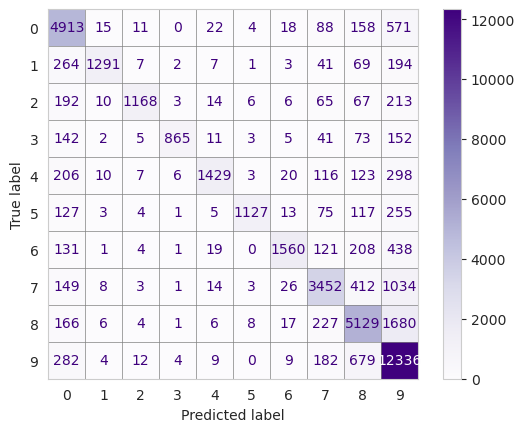

In [70]:
print("confusion matrix:\n", confusion_matrix(ysb_test,ys_pred))
print("classification report:\n", classification_report(ysb_test,ys_pred))
cm = confusion_matrix(ysb_test, ys_pred)
ConfusionMatrixDisplay(cm).plot(cmap='Purples')
ax = plt.gca()  #have to reset messy grid
ax.set_xticks([x - 0.5 for x in range(len(cm) + 1)], minor=True) 
ax.set_yticks([y - 0.5 for y in range(len(cm) + 1)], minor=True)
ax.grid(visible=True, which='minor', color='gray', linestyle='-', linewidth=0.5)
ax.tick_params(which="minor", size=0)
ax.grid(visible=False, which='major')
mse = mean_squared_error(ysb_test, ys_predict)
mae = mean_absolute_error(ysb_test, ys_predict)
r2 = r2_score(ysb_test, ys_predict)
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"R² Score: {r2:.4f}")

In [71]:
#accuracy of 77 is our best yet HECKKKK YEAH!!!!! There is however a decent chance this is on account of overfitting and adjusting to noise in the data
#with 100 estimators i retrieved an accuracy of 55
#though thinking about it, can you even really overfit a dataset of 215k instances?? hmm

# Dense Matrix Algorithms (gpu/CuML)
1. K Nearest Neighbors
2. SVM
3. Random Forests

In [72]:
tfidf = TfidfVectorizer(max_df=0.8, min_df=1, stop_words='english', max_features=1000) #stop_words is a parameter that excludes articles and other typical and unuseful words
# could not for the life of me find any hole of the internet explaining the error i was getting from a typle mismatch that didnt make any fing sense
# so essentially couldn't use my vocabulary=filtered_vocab as a parameter and used 1000 max features instead, kill me

#max_df and min_df exclude words that are very common and very rare
tfidf_matrix = tfidf.fit_transform(X)

In [73]:
tfidfbigram = TfidfVectorizer(ngram_range=(1, 2), max_df=0.8, min_df=5, max_features=2000, stop_words='english')  # Includes unigrams and bigrams (ex. great is a unigram, great product is a bigram)
#reminder that tfidfbigram is the vectorizer and the _matrix will be the actual X
tfidfbigram_matrix = tfidfbigram.fit_transform(X) #now a scipy sparse matrix (csr_matrix) object (compressed sparse matrix)

In [74]:
#had inital memory fail errors here i assumed because the sparse matrix is cpu side, but even with the cupy version still memory leak
tfidf_dense = cp.array(tfidf_matrix.toarray())

#IT DID FINALLY WORK WITH ONLY 1000 max features so whatever

In [75]:
from cuml.model_selection import train_test_split
from cuml.neighbors import KNeighborsClassifier
from cuml.metrics import confusion_matrix as CuML_cm
X_train, X_test, y_train, y_test = train_test_split(tfidf_dense, df["rating"], test_size=0.2, random_state=42) #dense model splits

In [76]:
from cuml.decomposition import TruncatedSVD

svd = TruncatedSVD(n_components=1000, random_state=42) #reduction to 1000 components to use for efficiency when necessary
Xr_train = svd.fit_transform(X_train)
Xr_test = svd.transform(X_test)

In [77]:
knn_model = KNeighborsClassifier(n_neighbors=1000, algorithm='auto') # Automatically selects the best method (so not brute lol)
# i found k=5, 15 were about the same accuracy wise (completly horrible) .32

#due to the ineffectiveness of the algorithm and the length of time necessary to run for each k value, the elbow method was not used to find the ideal k
#k values of 15, 463 (root of # instances) and 1000 were attempted with 1000 being most effective

In [78]:
knn_model.fit(Xr_train, y_train)

KNeighborsClassifier()

In [79]:
y_pred = knn_model.predict(Xr_test)

In [80]:
y_testcm = y_test.to_numpy()
y_predcm = y_pred.get()

In [81]:
print(type(y_predcm))

<class 'numpy.ndarray'>


In [82]:
cm = confusion_matrix(y_testcm, y_predcm)

In [83]:
print(type(cm))

<class 'numpy.ndarray'>


classification report:
               precision    recall  f1-score   support

           1       0.48      0.21      0.29      5879
           2       0.00      0.00      0.00      1839
           3       0.00      0.00      0.00      1754
           4       0.00      0.00      0.00      1309
           5       0.00      0.00      0.00      2122
           6       0.00      0.00      0.00      1747
           7       0.00      0.00      0.00      2526
           8       0.71      0.00      0.00      5070
           9       0.19      0.00      0.00      7263
          10       0.33      0.99      0.49     13503

    accuracy                           0.34     43012
   macro avg       0.17      0.12      0.08     43012
weighted avg       0.28      0.34      0.20     43012

Mean Squared Error (MSE): 17.5081
Mean Absolute Error (MAE): 2.7580
R² Score: -0.6254


/home/unavrgjoe/miniforge3/envs/rapids-24.10/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/unavrgjoe/miniforge3/envs/rapids-24.10/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/unavrgjoe/miniforge3/envs/rapids-24.10/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

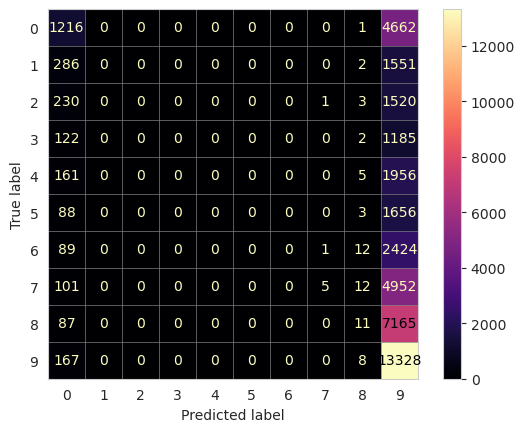

In [84]:
print("classification report:\n", classification_report(y_testcm,y_predcm))
ConfusionMatrixDisplay(cm).plot(cmap='magma')
ax = plt.gca()  #have to reset messy grid
ax.set_xticks([x - 0.5 for x in range(len(cm) + 1)], minor=True) 
ax.set_yticks([y - 0.5 for y in range(len(cm) + 1)], minor=True)
ax.grid(visible=True, which='minor', color='gray', linestyle='-', linewidth=0.5)
ax.tick_params(which="minor", size=0)
ax.grid(visible=False, which='major')
mse = mean_squared_error(y_testcm, y_predcm)
mae = mean_absolute_error(y_testcm, y_predcm)
r2 = r2_score(y_testcm, y_predcm)
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"R² Score: {r2:.4f}")

In [85]:
# increased the number of neigbors to 1000 and it took a rather long time to compute just to improve accuracy by 2%
#i am so done with this algorithm

SVM this time with a dense matrix 

In [91]:
from cuml.svm import LinearSVC #specialized solver recommended in the error when i tried to run SVC 

ran fast the first again with .38 accuracy so increasing nuber features and looking at effect

In [92]:
tfidf20k = TfidfVectorizer(max_df=0.8, min_df=1, stop_words='english', max_features=20000)
tfidf_matrix20k = tfidf20k.fit_transform(X)

In [93]:
tfidf_dense20k = cp.array(tfidf_matrix.toarray())

In [94]:
X_train20k, X_test20k, y_train, y_test = train_test_split(tfidf_dense20k, df["rating"], test_size=0.2, random_state=42)

In [95]:
svm = LinearSVC(  
    C=1,            # simplcity hardly changed accuracy so im sticking with 1
    probability=False, # i disabled probability estimates for efficiency
    #careful running this and not having a 3070
)
#verbose = true if need to

In [96]:
svm.fit(X_train20k, y_train)

LinearSVC()

/home/unavrgjoe/miniforge3/envs/rapids-24.10/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/unavrgjoe/miniforge3/envs/rapids-24.10/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/unavrgjoe/miniforge3/envs/rapids-24.10/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

classification report:
               precision    recall  f1-score   support

           1       0.37      0.63      0.46      5879
           2       0.00      0.00      0.00      1839
           3       0.00      0.00      0.00      1754
           4       0.00      0.00      0.00      1309
           5       0.00      0.00      0.00      2122
           6       0.00      0.00      0.00      1747
           7       0.00      0.00      0.00      2526
           8       0.00      0.00      0.00      5070
           9       0.16      0.09      0.11      7263
          10       0.42      0.89      0.57     13503

    accuracy                           0.38     43012
   macro avg       0.09      0.16      0.11     43012
weighted avg       0.21      0.38      0.26     43012

Mean Squared Error (MSE): 13.5103
Mean Absolute Error (MAE): 2.3064
R² Score: -0.2542


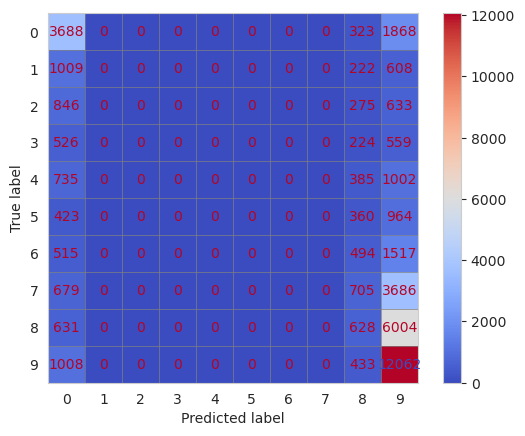

In [97]:
y_pred = svm.predict(X_test20k)
y_testcm = y_test.to_numpy()
y_predcm = y_pred.get()
cm = confusion_matrix(y_testcm, y_predcm)
print("classification report:\n", classification_report(y_testcm,y_predcm))
ConfusionMatrixDisplay(cm).plot(cmap='coolwarm')
ax = plt.gca()  #have to reset messy grid
ax.set_xticks([x - 0.5 for x in range(len(cm) + 1)], minor=True) 
ax.set_yticks([y - 0.5 for y in range(len(cm) + 1)], minor=True)
ax.grid(visible=True, which='minor', color='gray', linestyle='-', linewidth=0.5)
ax.tick_params(which="minor", size=0)
ax.grid(visible=False, which='major')
mse = mean_squared_error(y_testcm, y_predcm)
mae = mean_absolute_error(y_testcm, y_predcm)
r2 = r2_score(y_testcm, y_predcm)
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"R² Score: {r2:.4f}")

In [98]:
#increasing the number of features 20x did not increase the accuracy of the model, will continue with 1000 features in the future for less efficient algorithms
#accuracy of .38

Random Forest

In [99]:
from cuml.ensemble import RandomForestClassifier

In [100]:
rf = RandomForestClassifier(
    n_estimators=50,    # Fewer trees means faster
    max_depth=60,        # quicker splits
    max_features=0.8,   
    max_samples=0.8,    
    bootstrap=True,     
    random_state=42,    #likely going to be the most efficient parameters
)

/home/unavrgjoe/miniforge3/envs/rapids-24.10/lib/python3.12/site-packages/cuml/internals/api_decorators.py:344: UserWarning: For reproducible results in Random Forest Classifier or for almost reproducible results in Random Forest Regressor, n_streams=1 is recommended. If n_streams is > 1, results may vary due to stream/thread timing differences, even when random_state is set
  return func(**kwargs)


In [101]:
rf.fit(X_train, y_train)

RandomForestClassifier()

classification report:
               precision    recall  f1-score   support

           1       0.71      0.83      0.77      5879
           2       0.97      0.63      0.77      1839
           3       0.96      0.62      0.75      1754
           4       0.98      0.65      0.78      1309
           5       0.97      0.64      0.77      2122
           6       0.98      0.64      0.78      1747
           7       0.97      0.63      0.77      2526
           8       0.83      0.64      0.73      5070
           9       0.78      0.68      0.73      7263
          10       0.68      0.93      0.78     13503

    accuracy                           0.76     43012
   macro avg       0.88      0.69      0.76     43012
weighted avg       0.80      0.76      0.76     43012

Mean Squared Error (MSE): 5.1400
Mean Absolute Error (MAE): 0.8735
R² Score: 0.5228


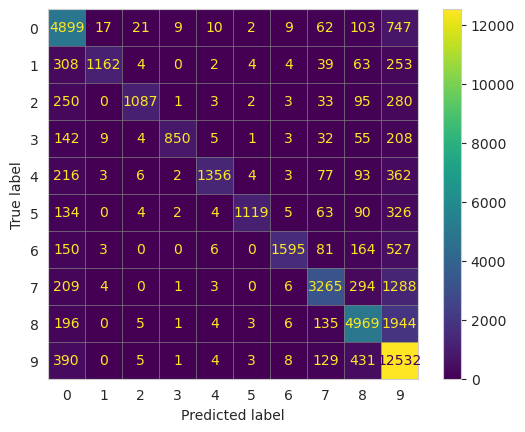

In [108]:
y_pred = rf.predict(X_test)
y_testcm = y_test.to_numpy()
y_predcm = y_pred.get()
cm = confusion_matrix(y_testcm, y_predcm)
print("classification report:\n", classification_report(y_testcm, y_predcm))
ConfusionMatrixDisplay(cm).plot(cmap='viridis')
ax = plt.gca()  #have to reset messy grid
ax.set_xticks([x - 0.5 for x in range(len(cm) + 1)], minor=True) 
ax.set_yticks([y - 0.5 for y in range(len(cm) + 1)], minor=True)
ax.grid(visible=True, which='minor', color='gray', linestyle='-', linewidth=0.5)
ax.tick_params(which="minor", size=0)
ax.grid(visible=False, which='major')
mse = mean_squared_error(y_testcm, y_predcm)
mae = mean_absolute_error(y_testcm, y_predcm)
r2 = r2_score(y_testcm, y_predcm)
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"R² Score: {r2:.4f}")

In [103]:
#random forest is trash?
#at 50 estimators and max_depth 8 accuracy of .33
#at 40 estimators and max_depth 40 accuracy of .60
#at 50 estimators and max_depth 60 accuracy of .71



#going for more but itll take a few hours lol

In [104]:
rf = RandomForestClassifier(
    n_estimators=60,    # Fewer trees means faster
    max_depth=100,        # quicker splits
    max_features=0.8,   
    max_samples=0.8,    
    bootstrap=True,     
    random_state=42,    #likely going to be the most efficient parameters
)

/home/unavrgjoe/miniforge3/envs/rapids-24.10/lib/python3.12/site-packages/cuml/internals/api_decorators.py:344: UserWarning: For reproducible results in Random Forest Classifier or for almost reproducible results in Random Forest Regressor, n_streams=1 is recommended. If n_streams is > 1, results may vary due to stream/thread timing differences, even when random_state is set
  return func(**kwargs)


In [105]:
rf.fit(X_train, y_train)

RandomForestClassifier()

classification report:
               precision    recall  f1-score   support

           1       0.71      0.83      0.77      5879
           2       0.97      0.63      0.77      1839
           3       0.96      0.62      0.75      1754
           4       0.98      0.65      0.78      1309
           5       0.97      0.64      0.77      2122
           6       0.98      0.64      0.78      1747
           7       0.97      0.63      0.77      2526
           8       0.83      0.64      0.73      5070
           9       0.78      0.68      0.73      7263
          10       0.68      0.93      0.78     13503

    accuracy                           0.76     43012
   macro avg       0.88      0.69      0.76     43012
weighted avg       0.80      0.76      0.76     43012

Mean Squared Error (MSE): 5.1400
Mean Absolute Error (MAE): 0.8735
R² Score: 0.5228


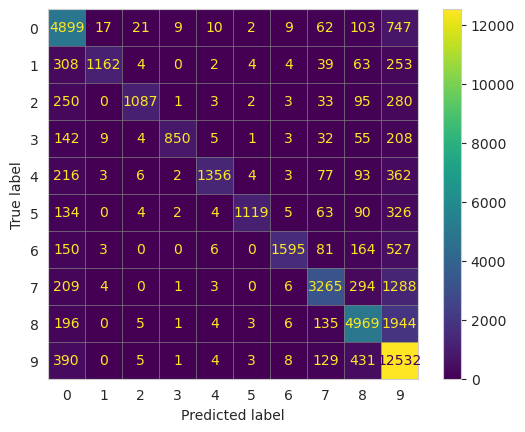

In [106]:
y_pred = rf.predict(X_test)
y_testcm = y_test.to_numpy()
y_predcm = y_pred.get()
cm = confusion_matrix(y_testcm, y_predcm)
print("classification report:\n", classification_report(y_testcm, y_predcm))
ConfusionMatrixDisplay(cm).plot(cmap='viridis')
ax = plt.gca()  #have to reset messy grid
ax.set_xticks([x - 0.5 for x in range(len(cm) + 1)], minor=True) 
ax.set_yticks([y - 0.5 for y in range(len(cm) + 1)], minor=True)
ax.grid(visible=True, which='minor', color='gray', linestyle='-', linewidth=0.5)
ax.tick_params(which="minor", size=0)
ax.grid(visible=False, which='major')
mse = mean_squared_error(y_testcm, y_predcm)
mae = mean_absolute_error(y_testcm, y_predcm)
r2 = r2_score(y_testcm, y_predcm)
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"R² Score: {r2:.4f}")

In [109]:
# this took well over an hour to run originally, 0.76 is likely to be the best accuracy i can reasonably achieve,
# 60 estimators and 100 max depth